<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

2021-09-06 15:53:18,918:INFO:Using device: cuda


## Data

In [67]:
from pl_bolts.datamodules import CIFAR10DataModule
import torchvision

def discretize(sample):
    return (sample * 255).to(torch.int32)




train_transforms = torchvision.transforms.Compose(
    [
        # torchvision.transforms.RandomCrop(32, padding=4),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        discretize,
    ]
)
test_transforms = torchvision.transforms.Compose(
    [
        # torchvision.transforms.RandomCrop(32, padding=4),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        discretize
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir="/datadrive/eman/datasets/cifar10",
    batch_size=64,
    num_workers=4,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

In [68]:
cifar10_dm.prepare_data()
cifar10_dm.setup()

Files already downloaded and verified
Files already downloaded and verified


In [69]:
train_dl = cifar10_dm.train_dataloader()

In [70]:
for ix, iy in train_dl:
    
    break

In [71]:
X_init = ix
X_init.shape

torch.Size([64, 3, 32, 32])

In [73]:
def plot_digits(data, num_x, num_y):
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = data[i]
        
        if data.ndim == 2:
            plottable_image = np.reshape(plottable_image, (3 ,32, 32))
        
        ax.imshow(plottable_image.transpose([1, 2, 0]), cmap='gray')
        ax.axis('off')
    plt.show()
    return None

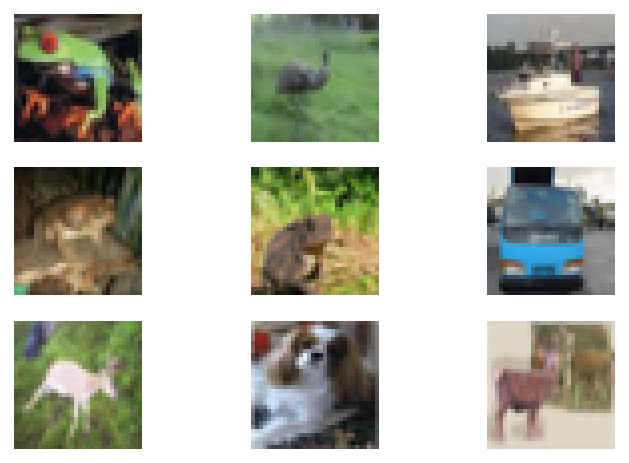

In [74]:
plot_digits(X_init.detach().cpu().numpy(), 3,3)

## Model

### Lightning Module

In [75]:
from src.experiments.cifar10.trainer import ImageFlow

In [10]:
import ml_collections

cfg = ml_collections.ConfigDict()
cfg.loss_fn = "inn"
cfg.num_epochs = 200
cfg.learning_rate = 1e-2
cfg.batch_size = 100
cfg.weight_decay = 0.0
cfg.beta1 = 0.9
cfg.beta2 = 0.999
cfg.betas = (cfg.beta1, cfg.beta2)


## Normalizing Flow Models

In [76]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.dequantization import UniformDequantization
from src.models.layers.convolutions import Conv1x1, Conv1x1Householder, ConvExponential

#### Coupling Network

In [12]:
# subset net
def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

### RealNVP Model

In [16]:
from src.models.layers.multiscale import SplitPrior

In [134]:
split_proportions = (1, X_init.shape[1] - 1)
split_proportions

(1, 2)

In [139]:
d = torch.zeros((3, 8, 8)).unsqueeze(0)
d.shape

torch.Size([1, 3, 8, 8])

In [81]:
prior = dist.Normal(0.0, 1.0)

inn = Ff.SequenceINN(4, 32, 32)

inn.append(
    SplitPrior,
    prior=prior
    
)
inn.append(
    Fm.RNVPCouplingBlock, 
    subnet_constructor=subnet_conv, 
)

[(4, 32, 32)]
(2, 32, 32)


In [82]:
demo_data = torch.zeros((1_000, 4, 32, 32))

z, log_jac_det = inn(demo_data)
print(z.shape)

torch.Size([1000, 2, 32, 32])


In [83]:
x_, log_jac_det = inn(z, rev=True)
print(x_.shape)

torch.Size([1000, 4, 32, 32])


#### Architecture

In [21]:
inn = Ff.SequenceINN(3, 8, 8)

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)

for ilayer in range(1):
    
    # COUPLING
    inn.append(
        Fm.RNVPCouplingBlock, 
        subnet_constructor=subnet_conv, 
    )

    # ACTNORM
    inn.append(
        Fm.ActNorm, 
    )
    
    # 1x1 CONVOLUTION
    inn.append(
        ConvExponential, 
    )
    
# UpSampling
inn.append(
    Fm.IRevNetUpsampling, 
)

#### Demo

torch.Size([100, 3, 8, 8])


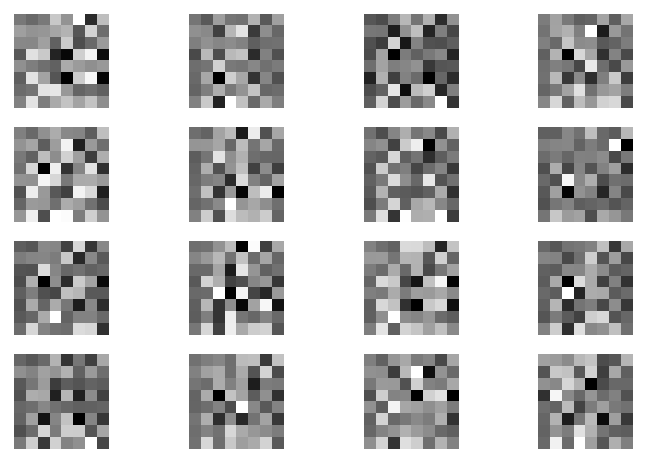

In [22]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

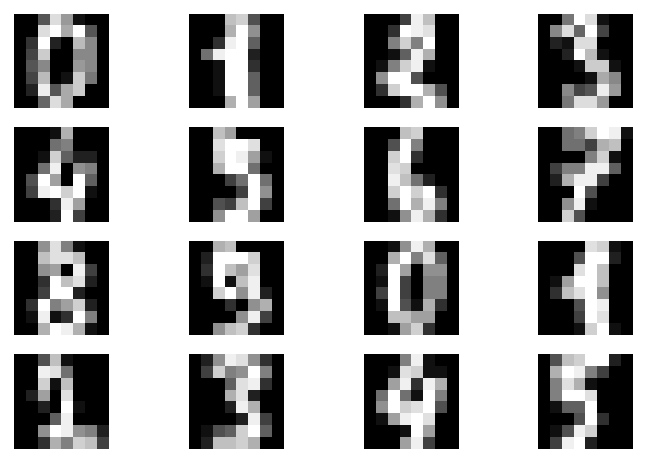

In [23]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori[:, 0, ...].detach().numpy(), 4, 4)

### GLOW Model

In [38]:
# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape)



torch.Size([100, 12, 4, 4])
torch.Size([100, 48, 2, 2])
torch.Size([100, 192, 1, 1])


#### Architecture

In [45]:
# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)



# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)


for ilayer in range(1):
    
    # COUPLING
    inn.append(
        Fm.GLOWCouplingBlock, 
        subnet_constructor=subnet_conv, 
    )

    # ACTNORM
    inn.append(
        Fm.ActNorm, 
    )
    
    # 1x1 CONVOLUTION
    inn.append(
        ConvExponential, 
    )
    
# UpSampling
inn.append(
    Fm.IRevNetUpsampling, 
)

#### Demo

torch.Size([100, 3, 8, 8])


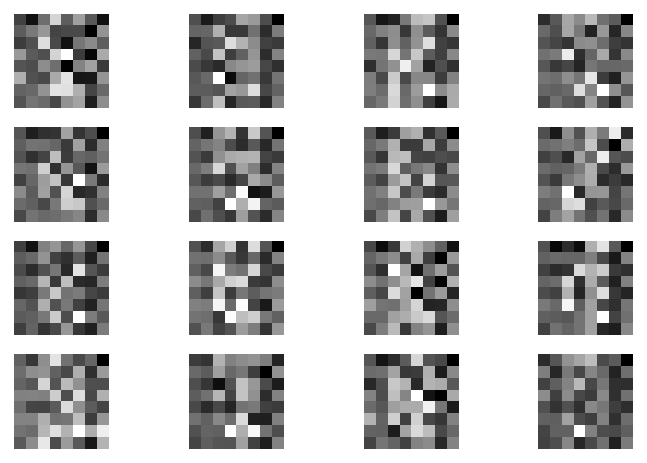

In [46]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

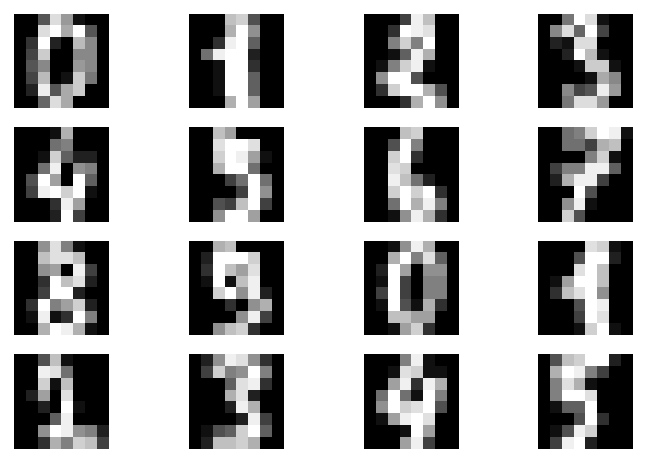

In [47]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori[:, 0, ...].detach().numpy(), 4, 4)

### Neural Spline Flows

In [31]:
from src.models.layers.coupling import get_coupling_layer
from src.models.nets.conv import ConvNet
from nflows.utils import create_mid_split_binary_mask


def nflows_covnet(dims_in, dims_out):
    return ConvNet(dims_in, 256, dims_out)

#### Architecture

In [32]:
# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)

# get new channels
n_channels_ = inn(X_init)[0].shape[1]

for ilayer in range(1):
    
    # COUPLING (NSF)
    coupling_transform = get_coupling_layer(coupling="rqs")
    
    mask = create_mid_split_binary_mask(features=n_channels_)
    
    inn.append(
        coupling_transform, 
        subnet_constructor=nflows_covnet,
        mask=mask,
        tails="linear",
        tail_bound=5,
        apply_unconditional_transform=False
    )

    # ACTNORM
    inn.append(
        Fm.ActNorm, 
    )
    
    # 1x1 CONVOLUTION
    inn.append(
        Conv1x1, 
    )
    
# UpSampling
inn.append(
    Fm.IRevNetUpsampling, 
)

#### Demo

torch.Size([100, 3, 8, 8])


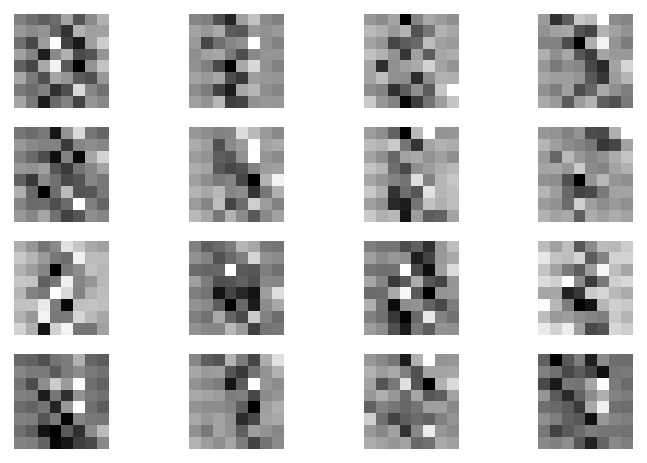

In [33]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

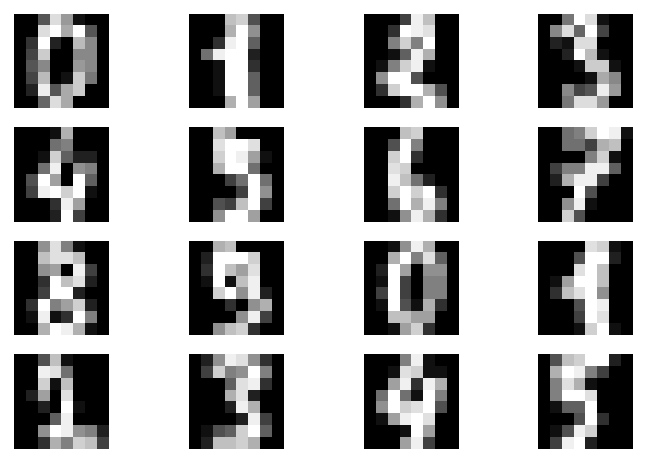

In [34]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori[:, 0, ...].detach().numpy(), 4, 4)

### Gaussianization Flows

In [95]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.multiscale import GeneralizedSplitPrior
from src.models.layers.dequantization import UniformDequantization
from src.models.layers.convolutions import Conv1x1Householder
from src.models.layers.mixtures import GaussianMixtureCDF
from src.models.layers.nonlinear import InverseGaussCDF
from src.experiments.utils import gf_propagate
from src.models.gaussianization import init_gaussianization_image_flow, init_gaussianization_flow

#### Initialization

#### Architecture

In [78]:
X_init.shape

torch.Size([64, 3, 32, 32])

In [79]:
X_init.min(), X_init.max()

(tensor(0, dtype=torch.int32), tensor(255, dtype=torch.int32))

#### Resolution I (Full)

In [125]:
from tqdm.notebook import trange
n_components=10

# for the initialization
init_X = ix.detach().clone()

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 32, 32)


# uniform dequantization (for integers)
# print("Dequantization")
inn.append(
    UniformDequantization,
    num_bits=8
)
init_X = gf_propagate(inn, init_X)

print("Input (Full Resolution):")
n_features, height, width = init_X.shape[1:]
print(
    f"Dims: {n_features} x {height} x {width} | Total Dims: {n_features*height*width}"
)

for _ in trange(1):

    inn, init_X = init_gaussianization_image_flow(inn=inn, init_X=init_X)

    
print("Input (Lower Resolution):")
# print("DownSampling")
inn.append(
    Fm.IRevNetDownsampling, 
)
init_X = gf_propagate(inn, init_X)
n_channels, height, width = init_X.shape[1:]
print(
    f"Dims: {n_channels} x {height} x {width} | Total Dims: {n_channels*height*width}"
)

for _ in trange(1):

    inn, init_X = init_gaussianization_image_flow(inn=inn, init_X=init_X)
    
print("Split (1/4):")

inn.append(
    GeneralizedSplitPrior,
    split=n_channels // 4,
    split_dim=0,
    prior=dist.Normal(0.0, 1.0),
)

init_X = gf_propagate(inn, init_X)
n_channels, height, width = init_X.shape[1:]
print(
    f"Dims: {n_channels} x {height} x {width} | Total Dims: {n_channels*height*width}"
)

print("Input (Lower Resolution):")
# print("DownSampling")
inn.append(
    Fm.IRevNetDownsampling, 
)
init_X = gf_propagate(inn, init_X)
n_channels, height, width = init_X.shape[1:]
print(
    f"Dims: {n_channels} x {height} x {width} | Total Dims: {n_channels*height*width}"
)


for _ in trange(1):

    inn, init_X = init_gaussianization_image_flow(inn=inn, init_X=init_X)
  
print("Split (1/4):")

inn.append(
    GeneralizedSplitPrior,
    split=n_channels // 4,
    split_dim=0,
    prior=dist.Normal(0.0, 1.0),
)

init_X = gf_propagate(inn, init_X)
n_channels, height, width = init_X.shape[1:]
print(
    f"Dims: {n_channels} x {height} x {width} | Total Dims: {n_channels*height*width}"
)

    
print("Input (Lower Resolution):")
# print("DownSampling")
inn.append(
    Fm.IRevNetDownsampling, 
)
init_X = gf_propagate(inn, init_X)
n_channels, height, width = init_X.shape[1:]
print(
    f"Dims: {n_channels} x {height} x {width} | Total Dims: {n_channels*height*width}"
)

for _ in trange(1):

    inn, init_X = init_gaussianization_image_flow(inn=inn, init_X=init_X)

    
print("Split (1/4):")
inn.append(
    GeneralizedSplitPrior,
    split=n_channels // 2,
    split_dim=0,
    prior=dist.Normal(0.0, 1.0),
)

init_X = gf_propagate(inn, init_X)
n_channels, height, width = init_X.shape[1:]
print(
    f"Dims: {n_channels} x {height} x {width} | Total Dims: {n_channels*height*width}"
)

print("Flatten (Fully Connected):")
# print("DownSampling")
inn.append(Fm.Flatten)

init_X = gf_propagate(inn, init_X)
n_features = init_X.shape[1:][0]
print(
    f"Dims: {n_features} | Total Dims: {n_features}"
)

for _ in trange(1):

    inn, init_X = init_gaussianization_flow(inn=inn, init_X=init_X)

Input (Full Resolution):
Dims: 3 x 32 x 32 | Total Dims: 3072


  0%|          | 0/1 [00:00<?, ?it/s]

Input (Lower Resolution):
Dims: 12 x 16 x 16 | Total Dims: 3072


  0%|          | 0/1 [00:00<?, ?it/s]

Split (1/4):
Dims: 3 x 16 x 16 | Total Dims: 768
Input (Lower Resolution):
Dims: 12 x 8 x 8 | Total Dims: 768


  0%|          | 0/1 [00:00<?, ?it/s]

Split (1/4):
Dims: 3 x 8 x 8 | Total Dims: 192
Input (Lower Resolution):
Dims: 12 x 4 x 4 | Total Dims: 192


  0%|          | 0/1 [00:00<?, ?it/s]

Split (1/4):
Dims: 3 x 4 x 4 | Total Dims: 48
Flatten (Fully Connected):
Dims: 48 | Total Dims: 48


  0%|          | 0/1 [00:00<?, ?it/s]

In [126]:
z, log_jac_det = inn(X_init)
z.shape

torch.Size([64, 48])

torch.Size([64, 12, 4, 4])
torch.Size([64, 12, 8, 8])
torch.Size([64, 12, 16, 16])


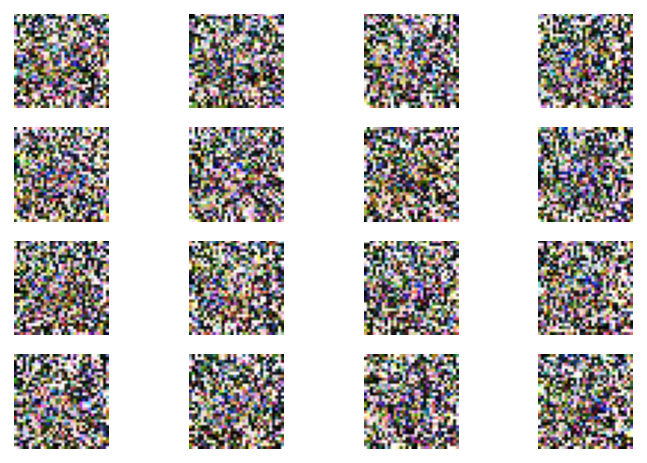

In [127]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori.detach().numpy(), 4, 4)

#### Resolution II (Lower)

#### Demo

In [85]:
z, log_jac_det = inn(X_init)
print(z.shape)
# plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

torch.Size([64, 12])


2021-09-06 16:47:33,439:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,476:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,501:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,549:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,574:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,600:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,634:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,658:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,685:WARNING:Too few points to create valid contours
2021-09-06 16:47:33,710:WARNING:Too few points to create valid contours


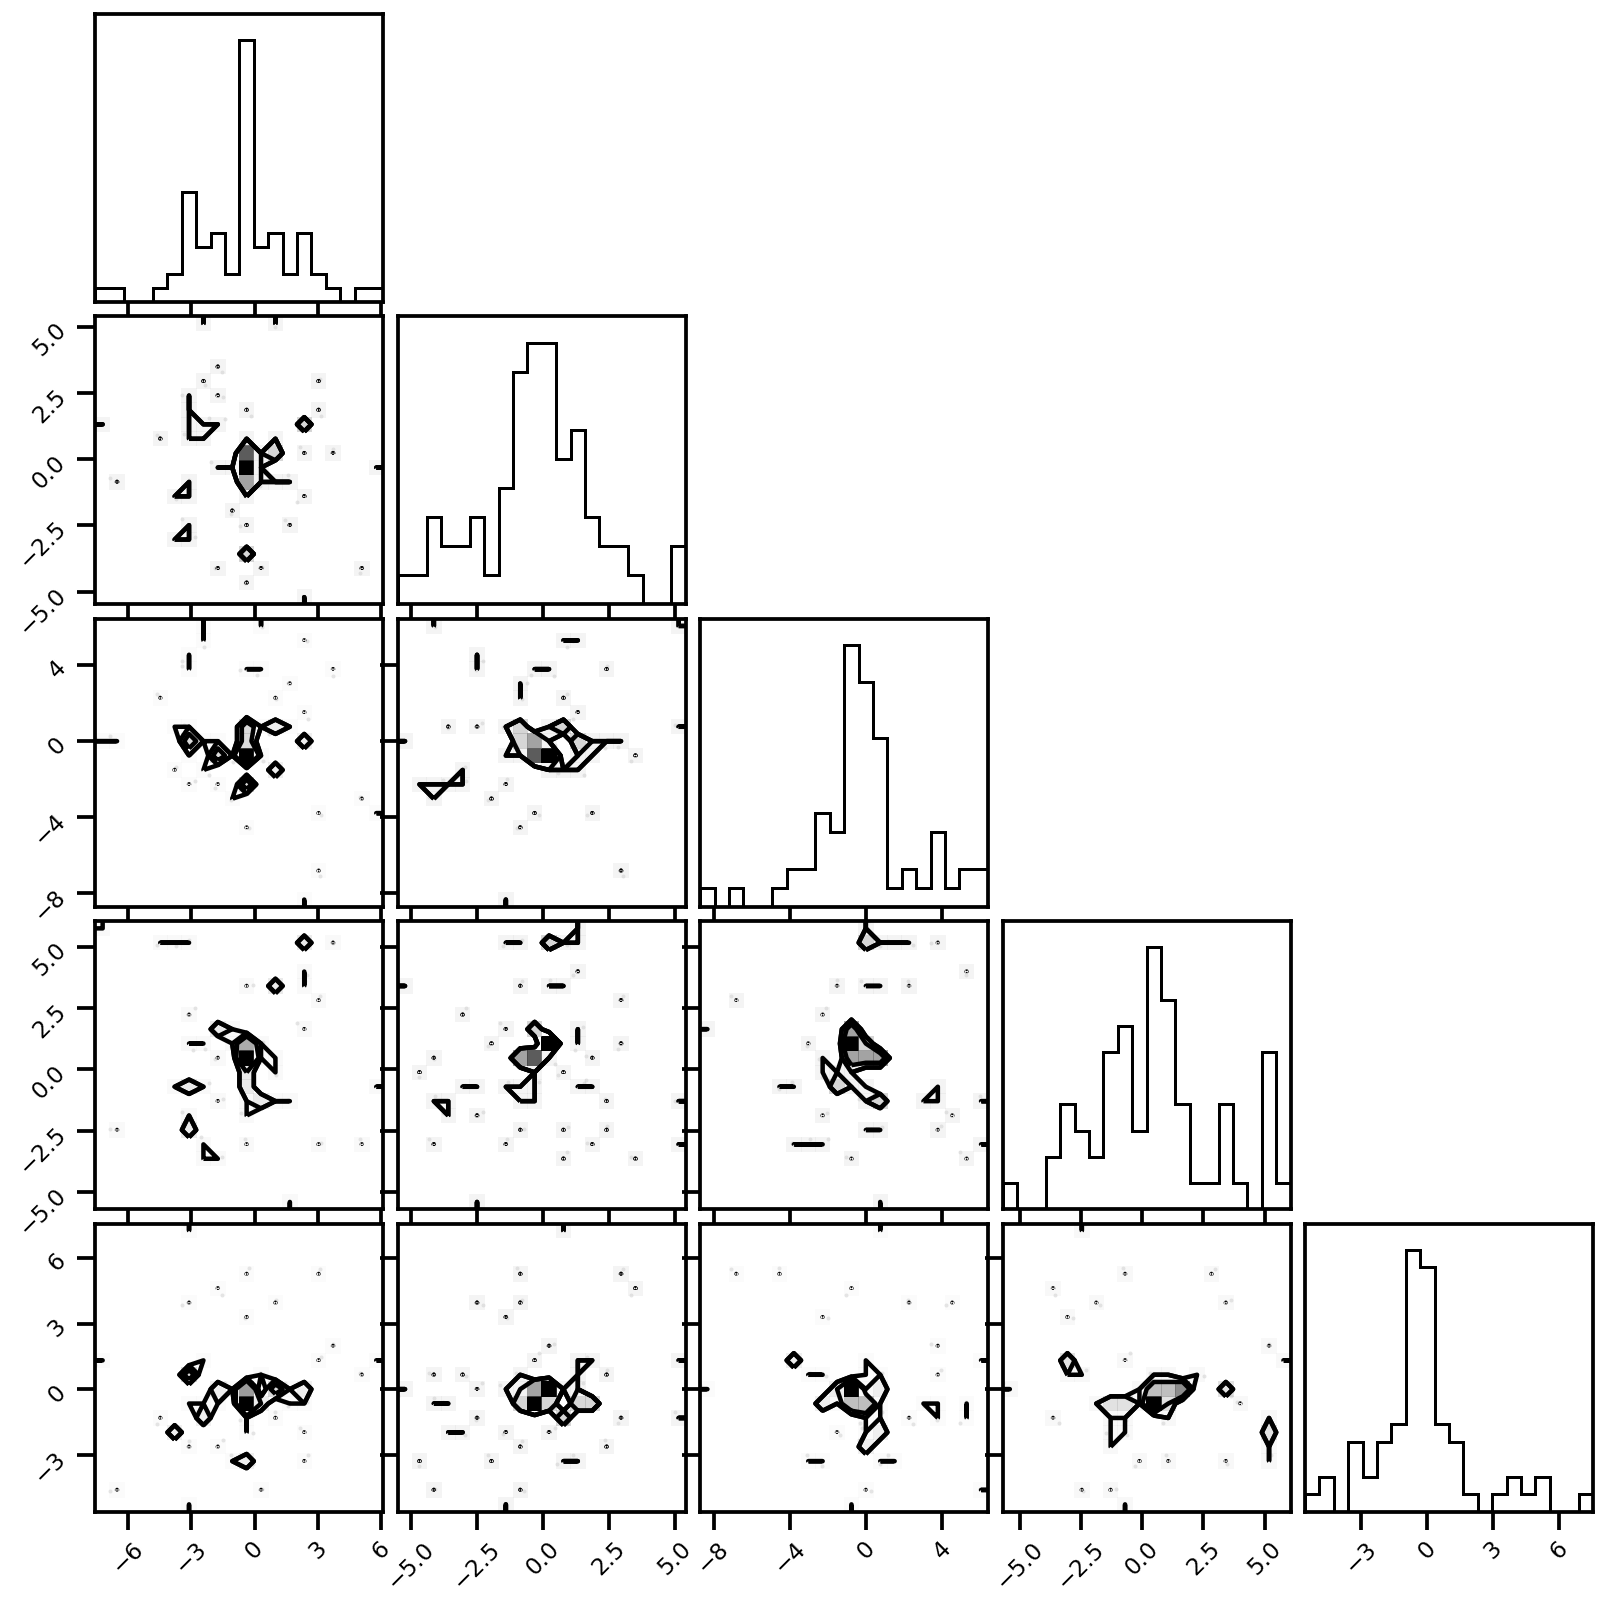

In [86]:
fig = corner.corner(z.detach().numpy()[:, :5])

In [87]:
x_ori.shape

torch.Size([64, 3, 32, 32])

torch.Size([64, 12, 2, 2])
torch.Size([64, 12, 4, 4])
torch.Size([64, 12, 8, 8])
torch.Size([64, 12, 16, 16])


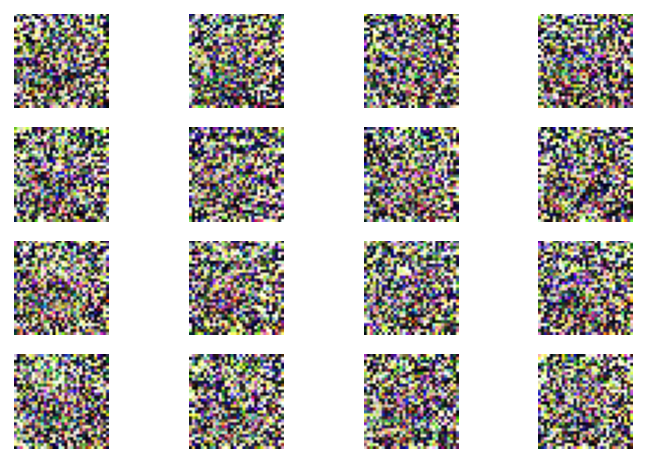

In [88]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori.detach().numpy(), 4, 4)

In [80]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

n_channels = 3
n_features = 3 * 64

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)
for ilayer in range(1):
    
#     # Glow Coupling
#     inn.append(
#         Fm.GLOWCouplingBlock, 
#         subnet_constructor=subnet_conv, 
#         )
    # NSF Coupling
    coupling_transform = get_coupling_layer(coupling="rqs")
    mask = create_mid_split_binary_mask(features=n_channels)
    inn.append(
        coupling_transform, 
        subnet_constructor=nflows_covnet,
        mask=mask,
        tails="linear",
        tail_bound=5,
        apply_unconditional_transform=False
    )
    
    # Orthogonal Transform
    coupling_transform = get_coupling_layer(coupling="rqs")
    mask = create_mid_split_binary_mask(features=n_channels)
    inn.append(
        coupling_transform, 
        subnet_constructor=nflows_covnet,
        mask=mask,
        tails="linear",
        tail_bound=5,
        apply_unconditional_transform=False
    )
    
#     # All-In-ONE-Block
#     inn.append(
#         Fm.AllInOneBlock, 
#         subnet_constructor=subnet_conv, 
#         permute_soft=False, 
#         gin_block=False, 
#         learned_householder_permutation=1
#         )
# inn.append(Fm.Flatten)
base_dist = dist.MultivariateNormal(torch.zeros(n_features), torch.eye(n_features))

#### Initial Transformation

torch.Size([100, 3, 8, 8])


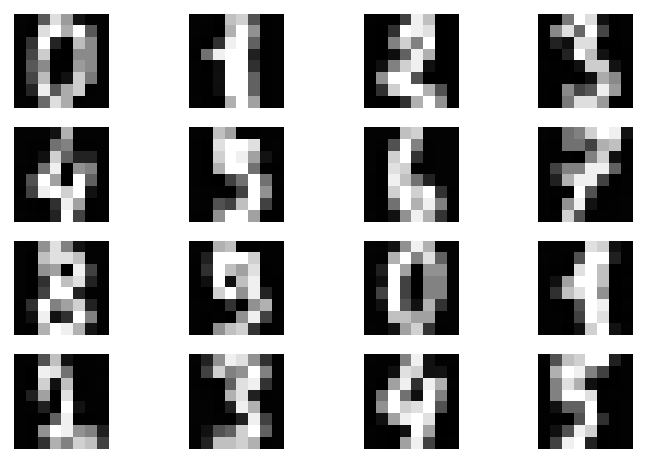

In [81]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

In [33]:
z.shape, X_init.shape

(torch.Size([100, 3, 8, 8]), torch.Size([100, 3, 8, 8]))

#### Inverse Transformation

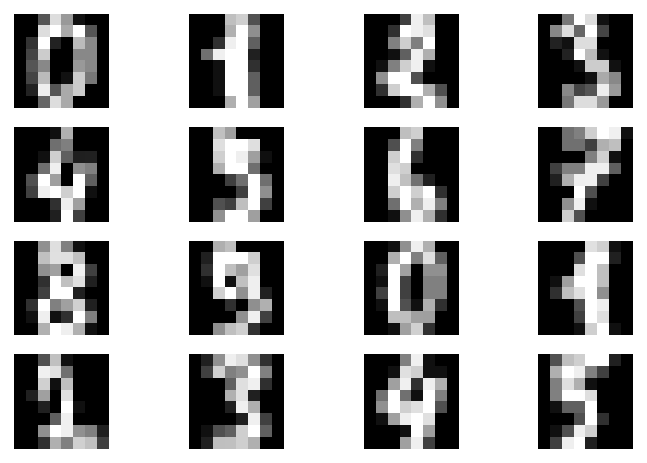

In [24]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori.detach().numpy(), 4, 4)

## Training

In [25]:
%%time

learn = FlowLearnerPlane(inn,  base_dist, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm'
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 464 K 
--------------------------------------
398 K     Trainable params
65.5 K    Non-trainable params
464 K     Total params
1.858     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

CPU times: user 1h 52min 59s, sys: 36.9 s, total: 1h 53min 35s
Wall time: 7min 4s


#### Latent Space

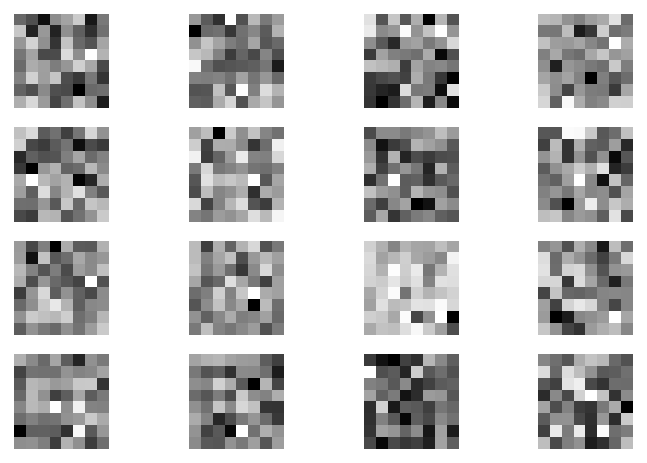

In [26]:
x = torch.Tensor(data_init)
z, log_jac_det = learn.model(x)

plot_digits(z.detach().numpy(), 4, 4)

2021-06-27 20:52:09,091:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,123:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,144:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,173:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,194:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,215:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,246:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,267:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,288:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,310:WARNING:Too few points to create valid contours


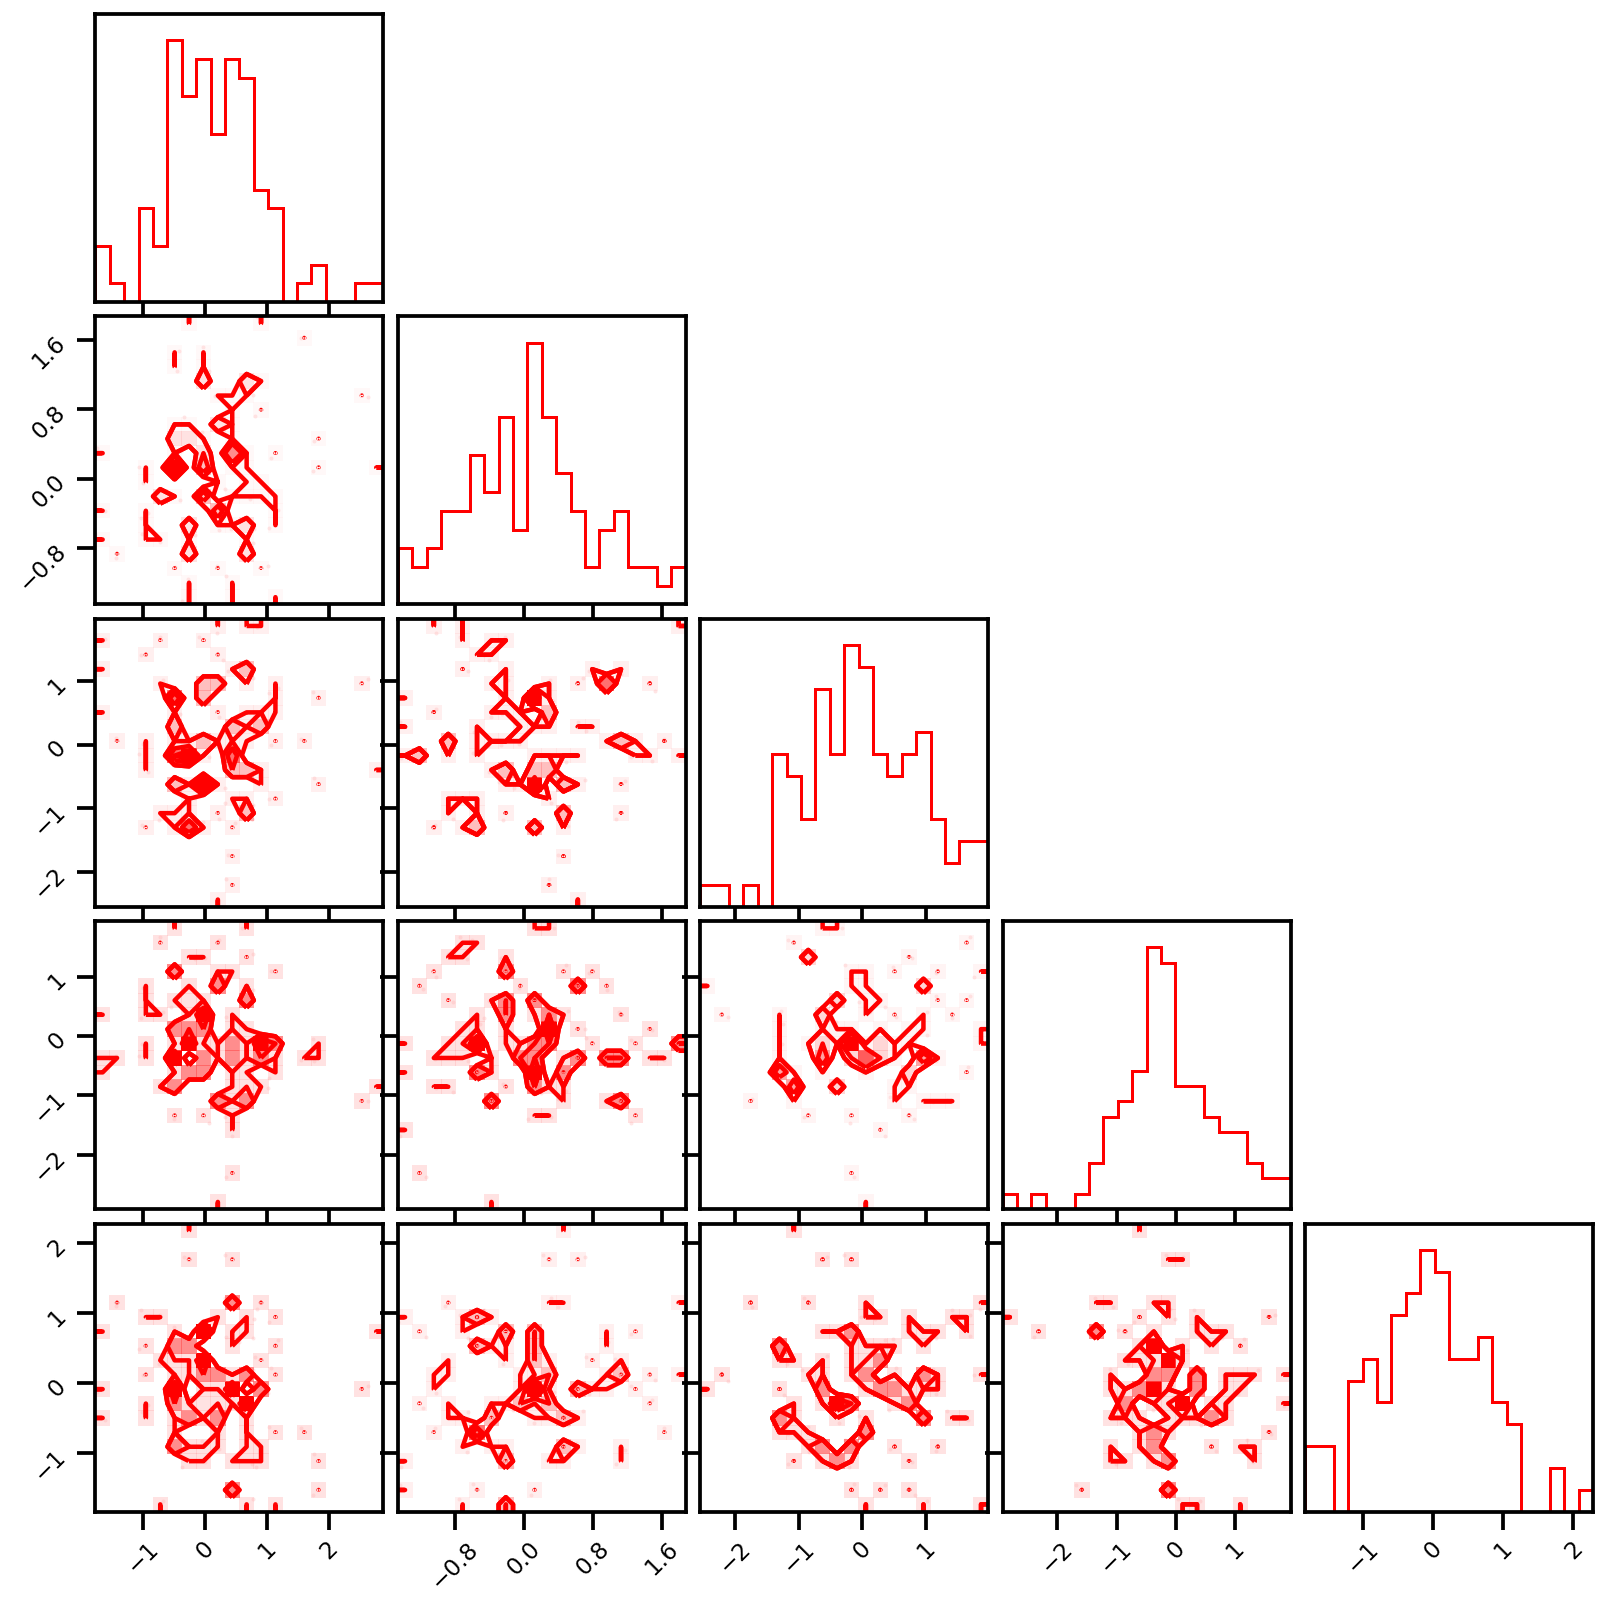

In [29]:
fig = corner.corner(z.detach().numpy()[:, :5], hist_factor=2, color="red")

#### Inverse Transform

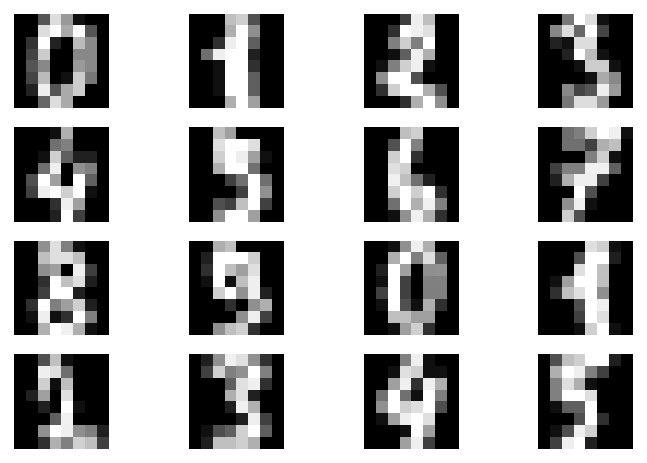

In [31]:
x_ori, _ = learn.model(z, rev=True)

plot_digits(x_ori.detach().numpy(), 4, 4)

2021-06-27 20:53:32,156:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,180:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,213:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,257:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,290:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,312:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,335:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,358:WARNING:Too few points to create valid contours


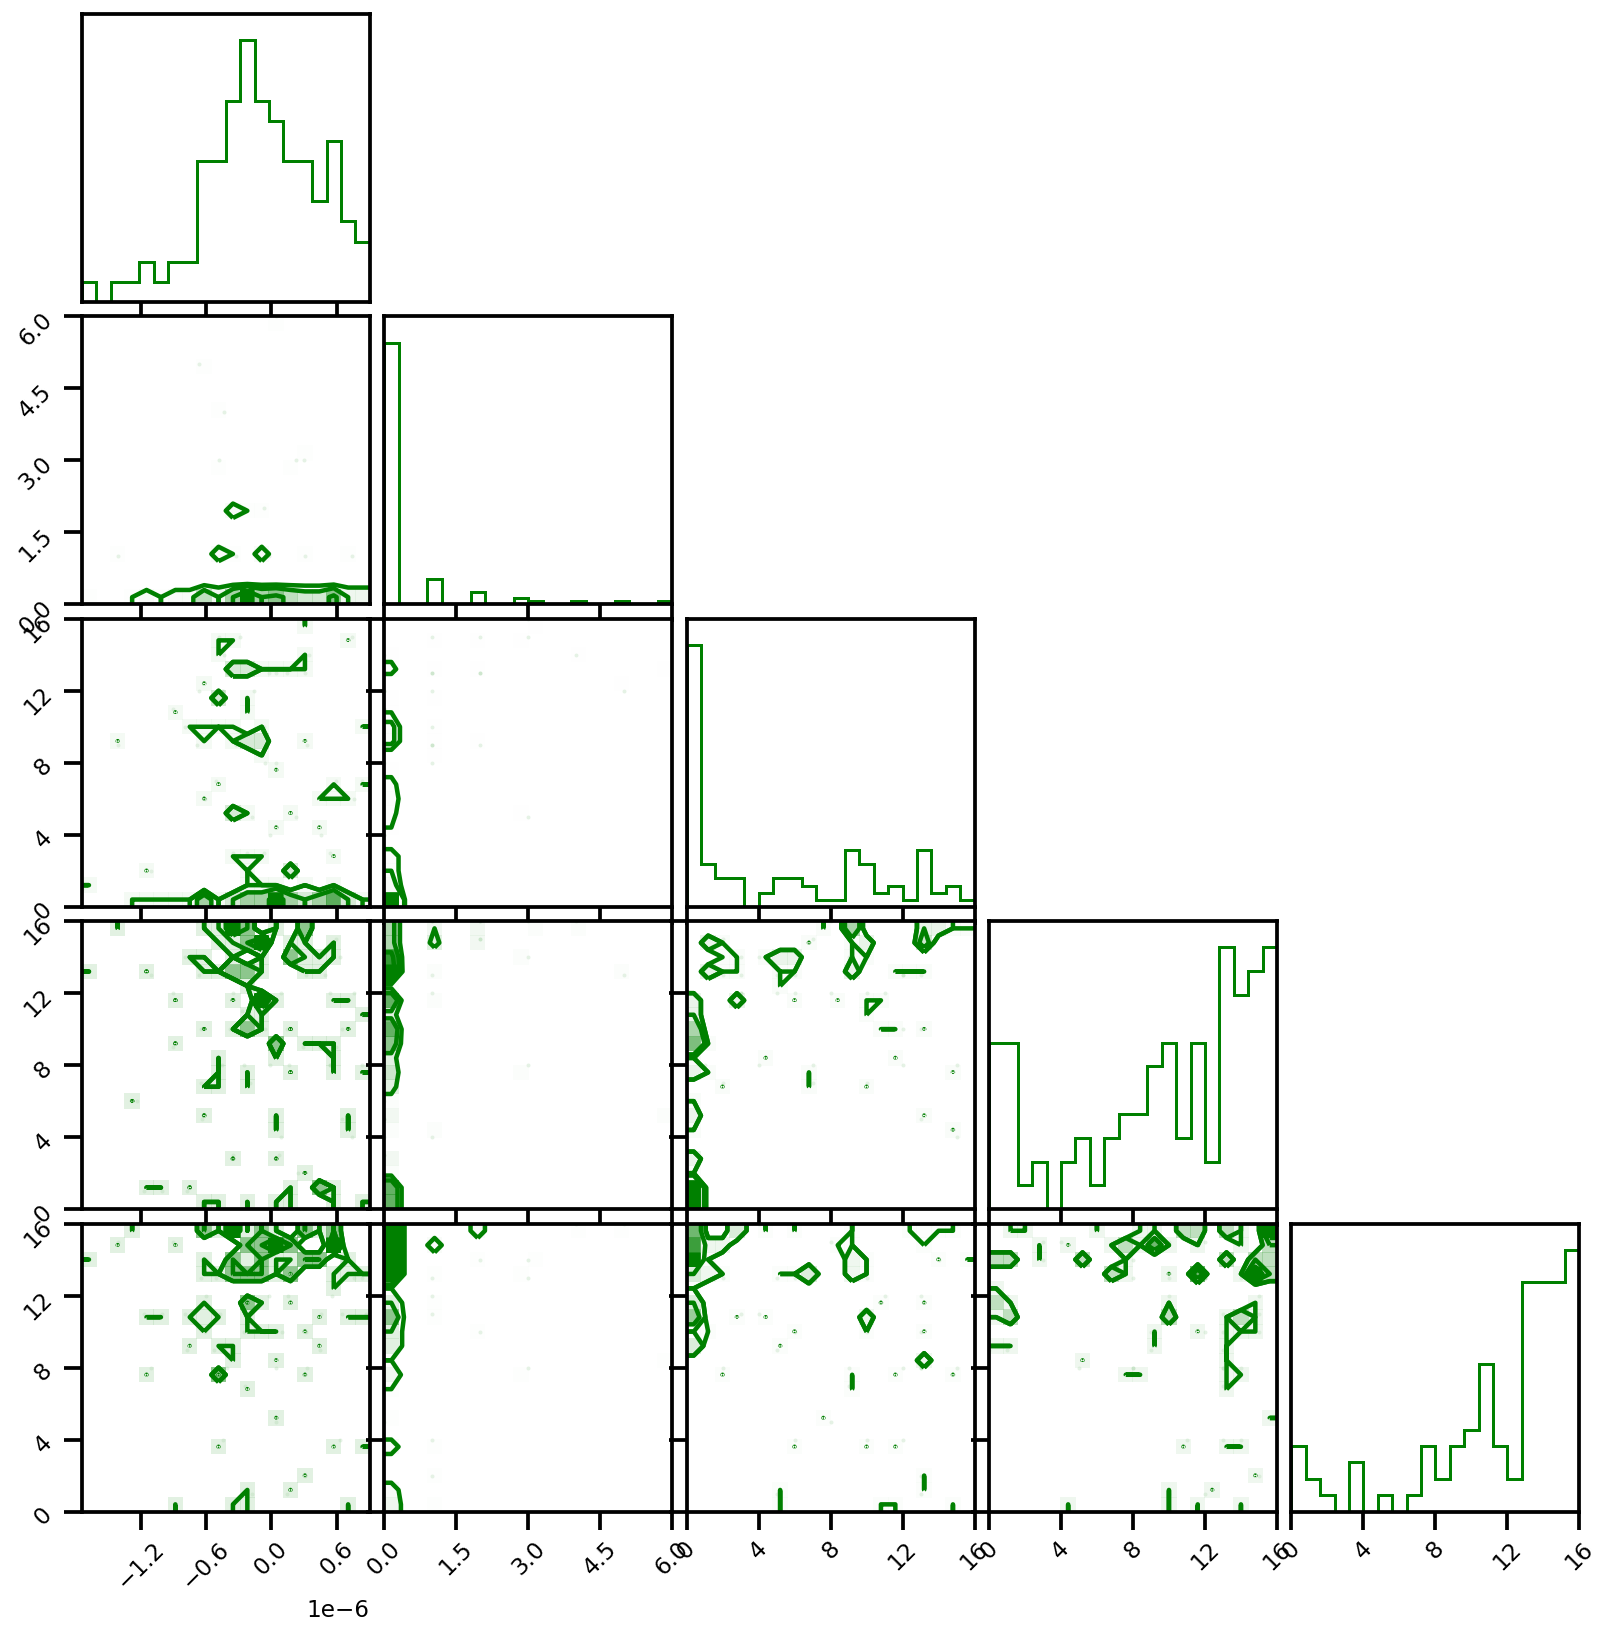

In [33]:
fig = corner.corner(x_ori.detach().numpy()[:, :5], hist_factor=2, color="green")

#### Sampling

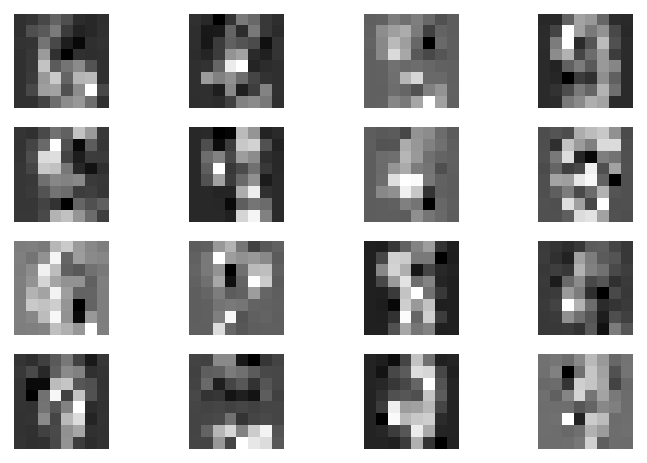

In [35]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 100
z = torch.randn(n_samples, N_DIM)
samples, _ = learn.model(z, rev=True)

plot_digits(samples.detach().numpy(), 4, 4)

In [ ]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")